In [1]:
from enum import IntEnum  # to find which correspond to what
import socket
import msgpack
import open3d as o3d
# import trimesh
from IPython.display import display, clear_output, display_svg, display_pretty
import numpy as np
import matplotlib.pyplot as plt
import time
import threading
import copy
import numba
import ipywidgets.widgets as widgets
import ipywidgets
from collections import defaultdict

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# %autoawait off

# import asyncio
# # # !pip install nest-asyncio
# import nest_asyncio
# # nest_asyncio.apply()

###########################################

PI = np.pi
TWO_PI = 2*np.pi

# UDP header constant
UDP_TERMINATE = -1
UDP_RESET = 15
UDP_ROBOT_STATE_REPORT = 14
UDP_MOTOR_VEL_COMMEND = 13
UDP_MOTOR_POS_COMMEND = 12


class UdpHeader(IntEnum):
    TERMINATE = UDP_TERMINATE
    RESET = UDP_RESET
    ROBOT_STATE_REPORT = UDP_ROBOT_STATE_REPORT
    MOTOR_SPEED_COMMEND = UDP_MOTOR_VEL_COMMEND
    MOTOR_POS_COMMEND = UDP_MOTOR_POS_COMMEND


ip_local = "127.0.0.1"
port_local = 32000

ip_remote = "127.0.0.1"
port_remote = 32001

BUFFER_LEN = 512  # in bytes

local_address = (ip_local, port_local)
remote_address = (ip_remote, port_remote)

packer = msgpack.Packer(use_single_float=True, use_bin_type=True)


# neam of command message
CMD_NAME = ("header", "t", "cmd")

# name of the returned message
REC_NAME = ("header",
            "t",           # simulation time [s]
            "joint_pos",   # joint angle [rad]
            "joint_vel",   # joint velocity [rad/s]
            "actuation",   # joint actuation [-1,1]
            "orientation", # base link (body) orientation
            "ang_vel",     # base link (body) angular velocity [rad/s]
            "com_acc",     # base link (body) acceleration
            "com_vel",     # base link (body) velocity
            "com_pos"      # base link (body) position
            )

ID =defaultdict(None,{name: k  for k,name in enumerate(REC_NAME)})

CMD_ID = defaultdict(None,{name: k  for k,name in enumerate(CMD_NAME)})

print(ID)
print(CMD_ID)

COMBINED_NAME = tuple(list(REC_NAME)[1:]+["cmd"])
print(COMBINED_NAME)

def rePack(d0,a):
    return d0[1:]+[a]

defaultdict(None, {'header': 0, 't': 1, 'joint_pos': 2, 'joint_vel': 3, 'actuation': 4, 'orientation': 5, 'ang_vel': 6, 'com_acc': 7, 'com_vel': 8, 'com_pos': 9})
defaultdict(None, {'header': 0, 't': 1, 'cmd': 2})
('t', 'joint_pos', 'joint_vel', 'actuation', 'orientation', 'ang_vel', 'com_acc', 'com_vel', 'com_pos', 'cmd')


### Create a UDP socket

In [2]:
# https://adaickalavan.github.io/programming/udp-socket-programming-in-cpp-and-python/
# Python UDP Receiver
#Create a datagram socket
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#Enable/disable immediate reuse of IP address
sock.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,0)
#Set a timeout so the socket does not block indefinitely when trying to receive data
sock.settimeout(1)
#Bind the socket to the port
sock.bind(local_address)
# sock.connect(remote_address)

# for closing connection:
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

### Start the simulation

In [3]:
# to start the simulation
import subprocess
import sys

# def run_simulation():
#     async def run_simulation_helfper():
#         return subprocess.Popen(["../build/flexipod.exe"])
#     asyncio.create_task(run_simulation_helfper())
# run_simulation()

## ref: https://stackoverflow.com/questions/16071866/non-blocking-subprocess-call
def run_simulation():
    task = subprocess.Popen(["../build/flexipod.exe"])
    time.sleep(0.6)
    return task
    
# sim = run_simulation()
# sim.terminate()

# import psutil # conda install psutil
# "flexipod.exe" in (p.name() for p in psutil.process_iter())

### test receiving udp packet

In [4]:
def item_to_String(key,value):
    try:
        return f"{key:<12s}:{','.join(f'{k:>+6.2f}' for k in value)}\n"
    except:
        return f"{key:<12s}:{value:>+6.2f}\n"

def test_udp_receive():
    s = time.perf_counter()
    try:
        data = sock.recv(BUFFER_LEN)
        data_unpacked = msgpack.unpackb(data)
        str_data = "".join([item_to_String(n,d) for n,d in zip(REC_NAME,data_unpacked)])
        print(str_data)

    except Exception as e:
        print(e)
        pass
    # sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
    # sock.close()# close the connection
    elapsed = time.perf_counter() - s
    print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")
    return data_unpacked
data = test_udp_receive()
str_data = "".join([item_to_String(n,d) for n,d in zip(REC_NAME,data)])

header      :+14.00
t           :+72.49
joint_pos   : +1.57, +1.57, -1.57, -1.57
joint_vel   : -0.00, +0.00, -0.00, +0.00
actuation   : +0.00, -0.00, +0.00, -0.00
orientation : +1.00, -0.00, +0.00, +0.00, +1.00, +0.00
ang_vel     : +0.00, -0.00, -0.00
com_acc     : -0.00, +0.00, -0.00
com_vel     : -0.00, +0.00, -0.00
com_pos     : -0.00, +0.00, +0.14

#--- executed in 0.23 ms ---#


In [5]:
sys.getsizeof(data)*400/1e6

0.0544

In [6]:
speed_command = [0.,0.,0.,0.]
data_combined = rePack(data,speed_command)

#  # create a msgpack packer object
# packer = msgpack.Packer(use_bin_type=True,use_single_float=False)
# with open("../data/test.mp", "wb+") as file:
    
#     s = time.perf_counter()
    
#     for i in range(100000):
#         file.write(packer.pack(data_combined))
        
#     elapsed = time.perf_counter() - s
#     print(f"#--- executed in {elapsed*1000:0.2f} ms ---#") 

In [7]:
[speed_command[CMD_ID["cmd"]]]

[0.0]

In [9]:
# https://github.com/jupyter-widgets/ipywidgets/blob/3bd75276370271e43ca5aa38d59a1848dfb65fb7/packages/controls/css/widgets-base.css

In [10]:
%%html
<style>
.widget-textarea textarea {
    color:black;
    border:clear;
}
.widget-textarea textarea:disabled {
  opacity: 1;
}
</style>

In [11]:
# text_widget = widgets.Textarea(
#     value=str_data,
#     description='',
#     disabled=True,
#     continuous_update=False,
#     layout={'border': 'clear',
#             'flex-flow': 'flex-wrap',
#             'width': '100%', 'height': '250px', 'max_width': '500px',
#             'margin': '0px 0px 0px 0px' }
# )
# display(text_widget)
# s = time.perf_counter()
# text_widget.value="".join([item_to_String(n,d) for n,d in zip(REC_NAME,data)])
# elapsed = time.perf_counter() - s
# print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")

### test sending udp packet

In [12]:
# s = time.perf_counter()
# handle.update(str_data)
# elapsed = time.perf_counter() - s
# print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")

In [13]:
# sen_sock = initUDP(ip_remote, port_local) # socket that send udp packet

data_send = [UDP_RESET,time.time(),[0,0,0,0]]
# data_send = [UDP_MOTOR_SPEED_COMMEND,time.time(),[2,2,-2,-2]]
# data_send = [UDP_TERMINATE,time.time(),[0,0,0,0]]

# data_send = [0.5,0.0,1.0,2.0]
# data_send = [1,2,3,4]

# data_send = 20

data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# data_send_packed = msgpack.packb(data_send)

num_bytes_send = sock.sendto(data_send_packed,remote_address)

print(data_send)
print(data_send_packed)

[15, 1606300867.7247214, [0, 0, 0, 0]]
b'\x93\x0f\xcaN\xbf|j\x94\x00\x00\x00\x00'


In [14]:
w_max = round(600.0/60.0*np.pi*2)
pos_max = np.pi
act_max = 1.0  # actuation

style_orientation = 'horizontal'
JOINT_NAME = ("frontLeft", "backLeft", "frontRight", "backRight")

slider_layout = ipywidgets.Layout(
    width='98%', height='12px', margin='0px 0px 0px 0px')
# slider_layout = ipywidgets.Layout(width='20px',height="140px")


def float_slider_template(min_max, step=0.01, value=0, disabled=True, layout=slider_layout):
    #     w =  widgets.FloatSlider(min=min_max[0], max=min_max[1], step=step, value=0,readout_format='.2f',
    #                         continuous_update=False, description="",orientation=style_orientation,
    #                         disabled=disabled, layout=layout)
    w = widgets.FloatProgress(min=min_max[0], max=min_max[1], step=step, value=0,
                              continuous_update=False, description="", orientation=style_orientation,
                              disabled=disabled, layout=layout)
    w.style.handle_color = 'red'
    return w


def creat_joint_box(joint_widgets):
    return widgets.GridBox(joint_widgets, layout=ipywidgets.Layout(
        width='100%', height='100%',
        #             grid_template_columns='repeat(2, 50%)',
        grid_template_columns='100%',
        grid_template_rows='auto',
        grid_gap='0px 0px',
        margin='0px 0px 0px 0px',
        align_items="flex-start", justify_items='flex-start',
        align_content="flex-start", justify_content='flex-start',
        border='clear'))


joint_vel_widgets = [float_slider_template(
    (-w_max, w_max)) for n in JOINT_NAME]
joint_pos_widgets = [float_slider_template(
    (-pos_max, pos_max)) for n in JOINT_NAME]
joint_cmd_widgets = [float_slider_template(
    (-w_max, w_max)) for n in JOINT_NAME]  # velocity command
joint_act_widgets = [float_slider_template(
    (-act_max, act_max)) for n in JOINT_NAME]

joint_vel_box = creat_joint_box(
    [widgets.Label("Joint vel [rad/s]")]+joint_vel_widgets)
joint_pos_box = creat_joint_box(
    [widgets.Label("Joint pos [rad]")]+joint_pos_widgets)
joint_cmd_box = creat_joint_box(
    [widgets.Label("joint vel command [rad/s]")]+joint_cmd_widgets)
joint_act_box = creat_joint_box(
    [widgets.Label("joint actuation []")]+joint_act_widgets)

joint_box = widgets.GridBox([joint_vel_box, joint_pos_box, joint_cmd_box, joint_act_box], layout=ipywidgets.Layout(
    width='100%', height='100%', max_width='500px',
    grid_template_columns='repeat(2, 50%)',
    grid_template_rows='auto',
    grid_gap='0px 0px',
    border='clear'))
# joint_box

In [15]:
layout_b = ipywidgets.Layout(width='100px')  # button layout

# stop button
button_stop = widgets.ToggleButton(
    value=False,
    description='stop',
    icon='stop',
    button_style='warning',
    layout=layout_b)

# restart button
button_restart = widgets.ToggleButton(
    value=False,
    description='restart',
    icon='refresh',
    button_style='warning',
    layout=layout_b)

# reset button
button_record = widgets.ToggleButton(
    value=False,
    description='record',
    icon='video-camera',
    button_style='success',
    layout=layout_b)

control_slider_layout = ipywidgets.Layout(width='400px')

speed_widget = widgets.FloatSlider(min=-int(w_max/2.5), max=int(w_max/2.5), step=1, value=0.0,
                                   continuous_update=False, description="Speed",
                                   layout=control_slider_layout)
speed_widget.style.description_width = '50px'

s_base_widget = widgets.FloatSlider(min=0.1, max=0.9, step=.02, value=0.6,
                                    continuous_update=False, description="s base",
                                    layout=control_slider_layout)
s_base_widget.style.description_width = '50px'

s_offset_widget = widgets.FloatSlider(min=-0.1, max=0.1, step=.005, value=0,
                                      continuous_update=False, description="s offset",
                                      layout=control_slider_layout, readout_format='.3f')
s_offset_widget.style.description_width = '50px'

gait_widget = widgets.ToggleButtons(
    options=[('rotate', 0), ('pace', 1), ('bound', 2),
             ('crawl', 3), ('random', 4)],
    description='gait:',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['rotation', 'pace gait',
              'bounding gait', 'crawl', 'random movement'],
    icons=[]
)
gait_widget.style.button_width = '80px'
gait_widget.style.description_width = '30px'

text_widget = widgets.Textarea(
#     value=str_data,
    value="",
    description='',
    disabled=True,
    continuous_update=False,
    layout={'border': 'clear',
            'flex-flow': 'flex-wrap',
            'width': '100%', 'height': '250px', 'max_width': '500px',
            'margin': '0px 0px 0px 0px'}
)

control_ui = widgets.VBox(
    (gait_widget, speed_widget, s_base_widget, s_offset_widget))

buttons_ui = widgets.HBox((button_stop, button_restart, button_record))
buttons_ui.layout.align_items = 'flex-start'

app = widgets.VBox([joint_box, text_widget, control_ui,
                    buttons_ui], layout={'border': 'clear', 'width': '100%', 'max_width': '500px',})
# display(app)

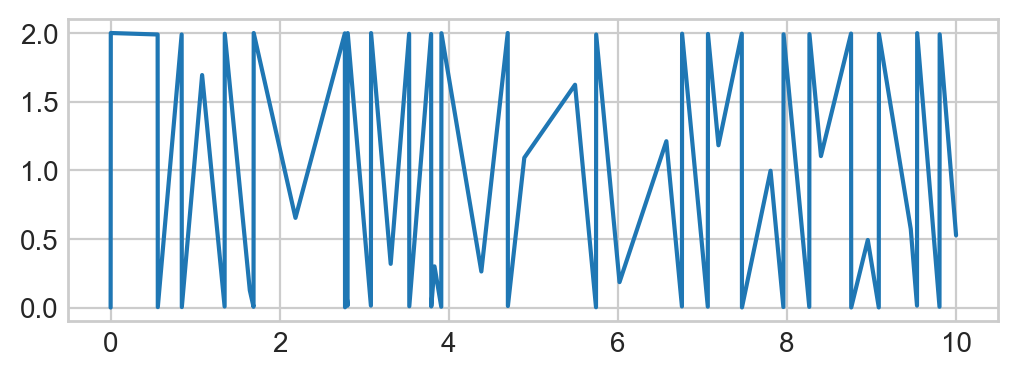

In [49]:
from numba import int32, float64,boolean    # import the types
from numba.experimental import jitclass
from numpy.linalg import norm
from numpy import expand_dims as NewDim
import numba

spec_RandomJointMotion = [
    ("w",float64),             # average angular velocity [rad/s]
    ("s",float64),             # stance ratio = stance_time/cycle_time [unitless]
    ("wmax",float64),          # max angular velocity [rad]
    ("t",float64),             # time at current step
    ("t_switch",float64),      # time at previous switch time
    ("pos",float64),           # position [rad]
    
]
#############################################
@jitclass(spec_RandomJointMotion)
class RandomJointMotion():
    """
    generate a random joint motion
    """
    def __init__(this, w, t=0.0):
        this.t = t # time at current step
        this.t_switch = t
        this.wmax = np.abs(w)
        this.w = np.random.uniform(-this.wmax,this.wmax)
        this.pos = 0
    def UpdateStanceRatio(this,s):
        pass
    def GetPos(this, t,w=None,s=None):
        if w is not None:
            this.wmax = np.abs(w)
        dt = t - this.t # differenct in raw time
        this.t=t
        if t-this.t_switch>np.random.uniform(0.5,2):
            this.t_switch = t
            this.w = np.random.uniform(-this.wmax,this.wmax)
        this.pos = (this.pos+this.w*dt)%TWO_PI
        return this.pos
    def UpdateAngularVelocity(this,t,w):        
        this.wmax = w # TODO direction
        
random_gait = [ # rotate gait
    RandomJointMotion(0.1),# front left
    RandomJointMotion(0.1), # back left
    RandomJointMotion(0.1), # back right
    RandomJointMotion(0.1)] # front right

t_arr = np.linspace(0,10,5000)
w_arr = 8*PI*np.ones_like(t_arr)
s_arr = np.linspace(0.5,0.5,len(t_arr))

angles = [np.array([g.GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)]) for g in random_gait]
plt.figure(figsize=(6,2),dpi=100)
plt.plot(t_arr,angles[0]/PI)
# for a in angles:
#     plt.plot(t_arr,a)

In [50]:
PI = np.pi
TWO_PI = 2*np.pi
spec_GaitTemplate = [
    ("ot",float64),            # normalized time offset [0-1], [unitless]
    ("w",float64),             # average angular velocity [rad/s]
    ("s",float64),             # stance ratio = stance_time/cycle_time [unitless]
    ("ws",float64),            # w_stance, (time normalized) average angular velocity of stance phase [rad]
    ("wa",float64),            # w_air, (time normalized) average angular velocity of air phase [rad]
    ("c",float64),             # contact_angle [rad]
    ("p_stance_mid",float64),  # angle at the middle of the stance phase [rad]
    ("p_stance_low",float64),  # angle at the start of the stance phase [rad]
    ("p_stance_high",float64), # angle at the end of the stance phase [rad]
    ("t",float64),             # time at current step
    ("tc",float64),            # converted time at current step [0,1]
    ("d",float64),             # direction of the time flow
    ("pos",float64),           # position [rad]
]
#############################################
@jitclass(spec_GaitTemplate)
class GaitTemplate():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 0.1*np.pi, # average angular velocity [rad/s]
                 s = 0.5, # stance ratio = stance_time/cycle_time [unitless]
                 c = 120/180*np.pi, # contact_angle [rad]
                 p_stance_mid = 1.*np.pi,# angle at the middle of the stance phase [rad]
                 t =0, # time at current step
                 d = 1.0 # direction of the time flow
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = w # average angular velocity [rad/s]
        this.c = c # contact_angle [rad]
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        this.p_stance_high = p_stance_mid + this.c/2.0
        this.d = d # direction of the time flow
        this.t = t # time at current step
        this.tc = this.ot # converted time [0-1,unitless]
                
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = this.c/(this.s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        this.wa = (TWO_PI-this.c)/(1-this.s) # w_air, (time normalized) average angular velocity of air phase [rad]
        
#         print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)

    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
        # update the converted (normalized) time this.tc
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = ws
        this.wa = wa
        
#         if this.tc<this.s: # 0-s
#             this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
#         else: # s-1
#             this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
            
    def GetPos(this, t,w=None,s=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w is not None:
            this.w = w
        if (s is not None) and s!=this.s:
            this.UpdateStanceRatio(s)
        dt = t - this.t # differenct in raw time
        this.t = t
        dnt = this.d*this.w*dt/TWO_PI # normalized phase difference [0-1][unitless]
        this.tc = (this.tc + dnt)%1.0 # # current converted time [0-1,unitless]
        if this.tc<0:
            this.tc= this.tc+1.0
        
        # todo sign
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
        return this.pos

    def UpdateAngularVelocity(this,t,w):        
        this.w = w # TODO direction  
    
rotation_gait = [ # rotate gait
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145./180*PI,d=1.0),# front left
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145./180*PI,d=1.0), # back left
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145./180*PI,d=-1.0), # back right
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145./180*PI,d=-1.0)] # front right

pace_gait = [ # pace gait
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145/180*PI),# front left
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back left
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back right
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145/180*PI)] # front right

bounding_gait = [ # bounding gait
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145/180*PI),# front left
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back left
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back right
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145/180*PI) # front right
]

crawl_gait = [ # crawl gait #2
    GaitTemplate(0,p_stance_mid = 1./2.*np.pi,c = 145/180*PI),# front left
    GaitTemplate(0.75,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back left
    GaitTemplate(0.25,p_stance_mid = 1./2.*np.pi,c = 145/180*PI), # back right
    GaitTemplate(0.5,p_stance_mid = 1./2.*np.pi,c = 145/180*PI) # front right
]

gaits = [rotation_gait,pace_gait,bounding_gait,crawl_gait,random_gait]

In [51]:
import math
from IPython.core.display import HTML
import datetime
display(HTML("<style>textarea, input { font-family: monospace; }</style>"))


control_update_interval = 1/200.
display_update_interval = 1/20.

speed_update_interval = 2.0


def flush_socket(sock):
    """
    start the simulation and flush out
    the oldest data in socket buffer
    """
#     sock.settimeout(1/10)
#     try:  # check if sim is tarted
#         data_receive = sock.recv(BUFFER_LEN)
#     except socket.timeout:
#         # likely the simulation is not started
#         sim = run_simulation()
    sock.settimeout(1/1000.)
    for k in range(1000):
        try:
            data_receive = sock.recv(BUFFER_LEN)
        except socket.timeout:
            break
#     print(k)
    sock.settimeout(1)


def AppControl():
    global gaits
    time_previous = 0
    display_timer = 0
    speed_timer = 0
    speed = 0.0  # speed of the robot
    previous_pos = np.array((0., 0., 0.))

    flag_start = True
    new_receive = False

    button_stop.value = False
    button_restart.value = False
    button_record.value = False
    flag_record = button_record.value
    recorded = False

    s_offset = 0
    s_base = 0.5

    pos_cmd = np.zeros(4, dtype=np.float64)  # joint positions command
    vel_cmd = np.zeros(4, dtype=np.float64)  # joint velocities command

    # previously commanded joint velocity
    joint_vel_prev = np.asarray((w.value for w in joint_vel_widgets))

    # reset the speed
    speed_widget.value = 0
    speed_string = ""
    desired_speed = 0
    gait_id = 0

    flush_socket(sock)

    # create a msgpack packer object
    packer = msgpack.Packer(use_bin_type=True)

    while flag_start:
        try:
            data_receive = sock.recv(BUFFER_LEN)
            data_receive_unpacked = msgpack.unpackb(data_receive,use_list=True)
            new_receive = True
            time_now = data_receive_unpacked[ID["t"]]
        except socket.timeout:
            #             print("rec_socket timed out!\r",end='')
            pass

        motor_pos_meas = np.asarray(data_receive_unpacked[ID["joint_pos"]])
        # assumming motor_pos_meas is in [-pi,pi]

        for k in range(4):
            pos = gaits[gait_id][k].GetPos(time_now)

            if desired_speed == 0:
                pos = np.pi/2  # set to standing position

            if k >= 2:
                pos = TWO_PI - pos
            if pos > PI:
                pos = pos-TWO_PI
            pos_cmd[k] = pos

            pos_error = pos - motor_pos_meas[k]

            if pos_error > PI:
                pos_error = -TWO_PI+pos_error
            elif pos_error < -PI:
                pos_error = TWO_PI+pos_error

            if gait_id<4:
                if abs(desired_speed) < 0.2:
                    vel_cmd[k] = (5+abs(desired_speed))*pos_error
                else:
                    vel_cmd[k] = 30*pos_error
            else:
                vel_cmd[k] = gaits[gait_id][k].w
                

        if time_now - display_timer > display_update_interval:
            display_timer = time_now
            if button_stop.value:
                flag_start = False
            if button_restart.value:
                speed_widget.value = 0
                data_send = [UDP_RESET, time.time(), [0, 0, 0, 0]]
                data_send_packed = packer.pack(data_send)
                num_bytes_send = sock.sendto(data_send_packed, remote_address)
                button_restart.value = False
            if flag_record != button_record.value:
                flag_record = button_record.value
                if flag_record:
                    recorded = True
                    # record starting time as file name
                    timestr = datetime.datetime.fromtimestamp(
                        time.time()).strftime("%Y%m%d-%H%M%S.%f")
                    # example format: '20190915-034034.694503'
                    # create a file
                    file_name = "../data/{}.mp".format(timestr)
                    file = open(file_name, "wb+")
                    print(f"started recording,file at {file_name}")

                file.write(packer.pack(COMBINED_NAME))
                # update speed every 3m travelled
            pos = np.asarray(data_receive_unpacked[ID["com_pos"]])
            dist = np.linalg.norm((pos - previous_pos)[:2])
            if dist > 3:
                speed = dist/(time_now - speed_timer)
                speed_timer = time_now
                previous_pos = pos
                speed_string = f"avg speed:{speed:<12.3f}\n"
            # update speed every speed_update_interval
            if time_now - speed_timer > speed_update_interval:
                speed_timer = time_now
                pos = np.asarray(data_receive_unpacked[ID["com_pos"]])
                speed = np.linalg.norm(
                    (pos - previous_pos)[:2])/speed_update_interval
                previous_pos = pos
                speed_string = f"avg speed:{speed:<12.3f}\n"

            desired_speed = speed_widget.value

            gait_id = gait_widget.value

            if (s_offset != s_offset_widget.value) or (s_base != s_base_widget.value):
                s_offset = s_offset_widget.value
                s_base = s_base_widget.value
                for k in range(4):
                    if k <= 2:
                        gaits[gait_id][k].UpdateStanceRatio(s_base-s_offset)
                    else:
                        gaits[gait_id][k].UpdateStanceRatio(s_base+s_offset)

            # data checking the header should be a certain number(TODO)
            if new_receive:
                new_receive = False
                text_widget.value = "".join([item_to_String(n, d) for n, d in zip(
                    REC_NAME, data_receive_unpacked)])+speed_string
                for k in range(4):
                    joint_vel_widgets[k].value = data_receive_unpacked[ID["joint_vel"]][k]
                    joint_act_widgets[k].value = data_receive_unpacked[ID["actuation"]][k]
                    joint_pos_widgets[k].value = pos_cmd[k]
                    joint_cmd_widgets[k].value = vel_cmd[k]
                    gaits[gait_id][k].UpdateAngularVelocity(
                        time_now, desired_speed)

        # send data
        data_send = (UDP_MOTOR_VEL_COMMEND, time_now, vel_cmd.tolist())
#             display(data_send)
        # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
        data_send_packed = packer.pack(data_send)
        sock.sendto(data_send_packed, remote_address)
        if flag_record:
            file.write(packer.pack(
                rePack(data_receive_unpacked, vel_cmd.tolist())))
    print("exit")
    if recorded:
        file.close()

# sim = run_simulation()
# sim.terminate()


control_thread = threading.Thread(target=AppControl)
display(app)
control_thread.start()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [9]:
# while
# try:
#     data_receive= sock.recv(BUFFER_LEN)
#     data_receive_unpacked = msgpack.unpackb(data_receive)
#     new_receive = True
#     time_now = data_receive_unpacked[ID["t"]]

action = (1,1,-1,-1)

data_send = (UDP_MOTOR_VEL_COMMEND,time.time(),action)
# display(data_send)
data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
sock.sendto(data_send_packed,remote_address)

_=test_udp_receive()

header      :14.000
T           :682.542
joint_pos   :1.574,1.573,1.481,1.554
joint_vel   :0.000,-0.001,-0.003,-0.000
com_acc     :-0.005,-0.002,-0.001
orientation :1.000,0.002,-0.000,-0.001,0.899,0.437
actuation   :-0.004,0.003,0.000,-0.000
com_pos     :0.004,-0.005,0.066
com_vel     :0.000,-0.000,0.000
#--- executed in 2.00 ms ---#


## rotation

In [ ]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h       

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def RotMatrixToQuarternion(m):
    """
    m is a 3x3 rotation matrix or 4x4 homogenious transformation matrix
    """
    w = np.sqrt(1+m[0,0]+m[1,1]+m[2,2])/2.0
    w4 = 4*w
    x = (m[2,1]-m[1,2])/w4
    y = (m[0,2]-m[2,0])/w4
    z = (m[1,0]-m[0,1])/w4
    return np.array([w,x,y,z])

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/index.htm
def QuarternionToAxisAngle(q):
    if(q[0]>1):
        q = q/np.linalg.norm(q)
    angle = 2.0 * np.arccos(q[0])
    s = np.sqrt(1-q[0]**2)
    if(s<1e-8):
        return q[1:],angle
    else:
        return q[1:]/s,angle

In [ ]:
m = RotateFromVec([0,1,1],np.pi/2.)
q = RotMatrixToQuarternion(m)
QuarternionToAxisAngle(q)

In [ ]:
def angle(x):
    return x- (x//np.pi)*(2*np.pi)

def angle2(x):
    if x<-np.pi:
        return x+np.pi*2
    elif x<np.pi:
        return x
    else:
        return x-np.pi*2
angle2 = np.vectorize(angle2)

In [ ]:
x = np.linspace(-2*np.pi,2*np.pi,1001)
y1 = angle(x)
y2 = angle2(x)

plt.plot(x/np.pi,y1/np.pi)
plt.plot(x/np.pi,y2/np.pi)

In [ ]:
import time
import asyncio

async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

async def test():
    print(f"started at {time.strftime('%X')}")

    await say_after(1, 'hello')
    await say_after(2, 'world')

    print(f"finished at {time.strftime('%X')}")

await test()

In [ ]:
task = asyncio.create_task(test())
print("this is reached")